In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np

#### Load stLearn data objects

In [2]:
visium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis4_cci.h5ad")
]

xenium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium6_cci.h5ad")
]

cosmx = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx0_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx6_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx7_cci.h5ad")
]

visium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in visium]
xenium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in xenium]
cosmx_cci = [sample.uns['per_lr_cci_cell_type'] for sample in cosmx]

visium_sizes = [sample.shape[0] for sample in visium]
xenium_sizes = [sample.shape[0] for sample in xenium]
cosmx_sizes = [sample.shape[0] for sample in cosmx]

In [3]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}
for i in range(len(visium_cci)):
    for lr_pair in visium_cci[i].keys():
        visium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(xenium_cci)):
    for lr_pair in xenium_cci[i].keys():
        xenium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(cosmx_cci)):
    for lr_pair in cosmx_cci[i].keys():
        cosmx_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

#### Normalise each group of samples

In [4]:
visium_normalised = mmcci.it.normalise_samples_to_target(
    visium_cci, visium_sizes, target=visium_sizes[0])
xenium_normalised = mmcci.it.normalise_samples_to_target(
    xenium_cci, xenium_sizes, target=xenium_sizes[0])
cosmx_normalised = mmcci.it.normalise_samples_to_target(
    cosmx_cci, cosmx_sizes, target=cosmx_sizes[0])

#### Group Patients

- 6747: vis4, cosmx1
- 21031: vis2, cosmx2, cosmx3
- 48974: vis1, cosmx4, cosmx5, cosmx6
- 66487: vis3, cosmx7, cosmx8



In [5]:
p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

[0.         0.15456607 0.58799878 0.         0.         0.03761679
 0.06045456 0.06712111 0.34042232 0.09909576 0.         0.01265823]


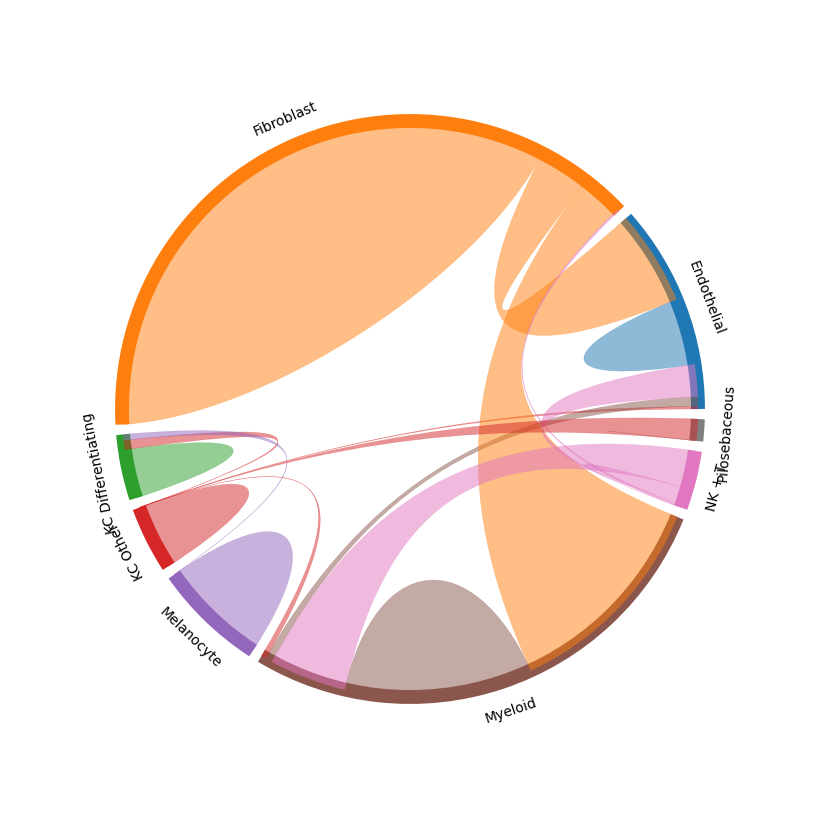

[0.         0.38524956 0.32609564 0.         0.         0.03418935
 0.12154077 0.02982133 0.36774689 0.06744556 0.         0.        ]


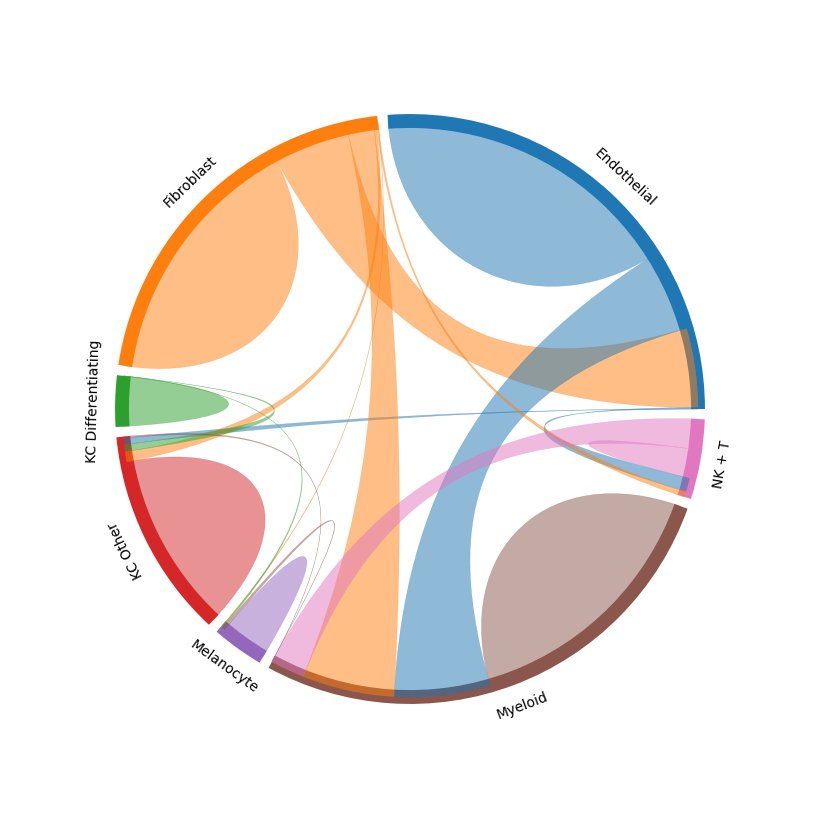

[0.         0.27903614 0.37387862 0.         0.         0.04234327
 0.18533446 0.00806193 0.29970125 0.25659472 0.         0.00064487]


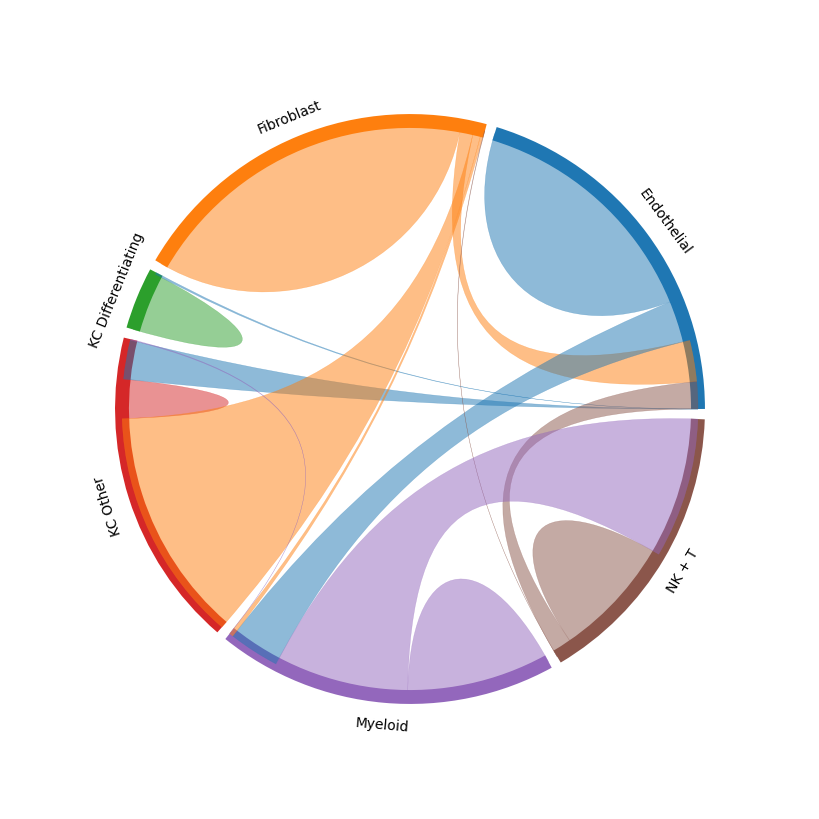

[0.         0.29334441 0.73444828 0.         0.         0.
 0.00646208 0.05222827 0.28602439 0.00590265 0.         0.        ]


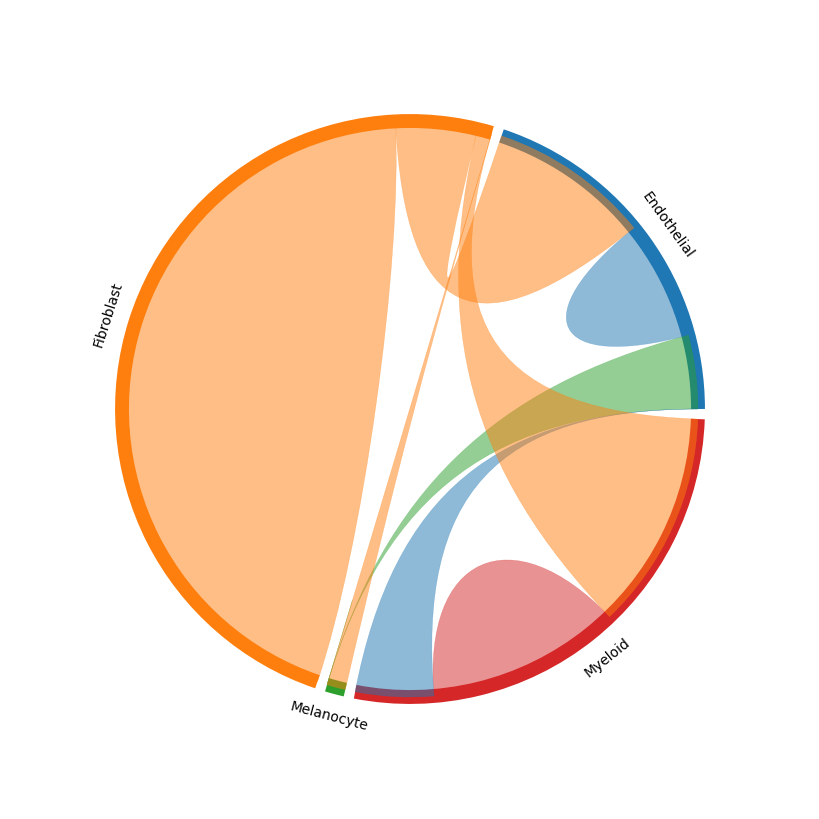

In [6]:
patient_integrated = {}

for patient, samples in patients.items():
    lr_pairs = mmcci.it.get_majority_lr_pairs(samples['vis'] + samples['cos'])
    visium_avg = mmcci.it.get_avg_lr_pairs(visium_normalised, lr_pairs)
    vis = mmcci.it.get_avg_lr_pairs(samples['vis'], lr_pairs)
    cos = mmcci.it.get_avg_lr_pairs(samples['cos'], lr_pairs)
    normalised = mmcci.it.normalise_samples_between_tech([[vis], [cos]])
    normalised = np.array(normalised).T.tolist()
    integrated = mmcci.it.integrate_between_tech(normalised[0])
    overall = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.chord_plot(overall)
    mmcci.plt.network_plot(overall)

#### Subset to only LR pairs present in majority of samples

#### Calculate average value of each LR pair across each group

In [ ]:
lr_pairs = mmcci.it.get_majority_lr_pairs(
    visium_normalised + xenium_normalised + cosmx_normalised)

visium_avg = mmcci.it.get_avg_lr_pairs(visium_normalised, lr_pairs)
xenium_avg = mmcci.it.get_avg_lr_pairs(xenium_normalised, lr_pairs)
cosmx_avg = mmcci.it.get_avg_lr_pairs(cosmx_normalised, lr_pairs)

#### Normalise samples between technologies

In [ ]:
normalised = mmcci.it.normalise_samples_between_tech(
    [[visium_avg], [xenium_avg], [cosmx_avg]])

#### Integrate between technologies for both groups

In [ ]:
# Transpose to get lists of groups instead of techs
normalised = np.array(normalised).T.tolist()
integrated = mmcci.it.integrate_between_tech(normalised[0])

#### Calculate overall interactions network per group

In [ ]:
overall = mmcci.it.calculate_overall_interactions(integrated)

#### Plot overall network

In [ ]:
mmcci.plt.network_plot(overall)

#### Get LR pairs from Vascular to Astrocytes

In [ ]:
myl_mel_lrs = mmcci.it.get_lrs_per_celltype([integrated], "Myeloid", "Melanocyte")
print("LR pairs from Myeloid to Melanocyte")
print(myl_mel_lrs['sample1'])

#### Cluster aged and young lr pairs

In [ ]:
clusters = mmcci.it.lr_clustering(integrated, n_clusters=0)
integrated_clusters = mmcci.it.subset_clusters(integrated, clusters)
overall_clusters = mmcci.it.calculate_cluster_interactions(integrated_clusters)

In [ ]:
for cluster, matrix in overall_clusters.items():
    print("\ncluster" + str(cluster) + ": Contains " +
          str(len(integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.network_plot(matrix)